In [98]:
# import packages
import pandas as pd
import numpy as np
import datetime
import math
from scipy.optimize import minimize, BFGS, LinearConstraint
from scipy.stats.mstats import gmean
import matplotlib.pyplot as plt

from SEIRWWfiles_R2S.SEIRWWcalibrate import SEIRWWcalibrate
from SEIRWWfiles_R2S.SEIRWWinit import SEIRWWinit


from SEIRWWfiles_R2S.DataBase import get_dataframe

In [99]:
# import packages
import os
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
#from datetime import datetime, timedelta
import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from matplotlib.backends.backend_pdf import PdfPages

from SEIRWWfiles_R2S.SEIR_WW import SEIR_WW
from SEIRWWfiles_R2S.SEIRWWinit import SEIRWWinit
from SEIRWWfiles_R2S.WWinterpol import WWinterpol
from SEIRWWfiles_R2S.SEIR_WW_FWD import SEIR_WW_FWD
from SEIRWWfiles_R2S.prediction import prediction

In [100]:
import scipy as sp
print(pd.__version__)
print(np.__version__)
print(sp.__version__)
import platform
print(platform.system())
print(platform.release())

1.3.5
1.21.6
1.7.3
Linux
4.19.0-25-cloud-amd64


In [101]:
# Run control
run_config = pd.read_csv('run_config.txt', sep=":")
run_config = run_config.transpose()

# Drop data by date
f_date = str(run_config.date_cut_from.iloc[0].strip())
l_date = str(run_config.date_cut_learn.iloc[0].strip())
t_date = str(run_config.date_cut_to.iloc[0].strip())

# Set global variables
geom_id = int(run_config.geom_id.iloc[0])
geom_id_idx = run_config.geom_id_idx.iloc[0].strip()

ww_idx = run_config.ww_idx.iloc[0].strip()
assay_method = run_config.assay_method.iloc[0].strip()
regionName = run_config.region_name.iloc[0].strip()
setting_path = run_config.setting_path.iloc[0].strip()
spe_day_flg = bool(run_config.spe_day_flg.iloc[0].strip())
N_days_pred = int(run_config.N_days_pred.iloc[0])
aggregation = run_config.aggregation[0].strip()
# vaccine setting
vaccine_efficacy_rate = float(run_config.vaccine_efficacy_rate.iloc[0])
acutial_vaccination_rate = float(run_config.acutial_vaccination_rate.iloc[0])
# contact reduce rate setting
contact_reduce_rate = float(run_config.contact_reduce_rate.iloc[0])
# s_init setting
s_init = float(run_config.s_init.iloc[0])
run_config

,date_cut_from,date_cut_learn,date_cut_to,auto_date_cut,region_name,debug,geom_id_idx,geom_id,aggregation,assay_method,ww_idx,setting_path,spe_day_flg,N_days_pred,vaccine_efficacy_rate,acutial_vaccination_rate,contact_reduce_rate,s_init
key value,2021-11-01,2022-01-30,2022-05-27,True,Kanagawa,True,geom_id_1,6,gmean,CM,covn_1_to_pmmov_user01,./settings/settings.xlsx,True,120,0.6,0.7,0.10,0.95


In [102]:
#figure_title="Kyoto (COPMAN)"
#figure_title="City A (EPISENS-S)"
#figure_title="Kanagawa (EPISENS-S)"
figure_title="Kanagawa (COPMAN)"

# Common parameters
spe_day_flg = True
N_days_pred = 120
# vaccine setting
vaccine_efficacy_rate = 0.6
acutial_vaccination_rate = 0.7
# contact reduce rate setting
contact_reduce_rate = 0.1

# Get data
if figure_title=="Kyoto (COPMAN)":
    df_tmp0 = pd.read_excel("./data-ww-case/Kyoto-CM.xlsx")
    df_tmp1 = pd.read_excel("./data-ww-case/Kyoto-cases.xlsx")
    # Drop data by date
    f_date = pd.to_datetime("2021-12-15")
    l_date = pd.to_datetime("2022-01-18")
    #l_date = pd.to_datetime("2022-08-31") original
    t_date = pd.to_datetime("2022-08-31")
    # s_init setting
    s_init = 0.95
    regionName = "Kyoto_kyotoshi"
elif figure_title=="Kanagawa (EPISENS-S)":
    df_tmp0 = pd.read_excel("./data-ww-case/Kanagawa-HS.xlsx")
    df_tmp1 = pd.read_excel("./data-ww-case/Kanagawa-cases.xlsx")
    # Drop data by date
    f_date = pd.to_datetime("2021-11-01")
    l_date = pd.to_datetime("2022-01-30")
    t_date = pd.to_datetime("2022-05-27")
    # s_init setting
    s_init = 0.95
    regionName = "Kanagawa"
elif figure_title=="Kanagawa (COPMAN)":
    df_tmp0 = pd.read_excel("./data-ww-case/Kanagawa-CM.xlsx")
    df_tmp1 = pd.read_excel("./data-ww-case/Kanagawa-cases.xlsx")
    # Drop data by date
    f_date = pd.to_datetime("2022-07-08")
    l_date = pd.to_datetime("2022-08-04")
    t_date = pd.to_datetime("2022-12-27")
    # s_init setting
    s_init = 0.9244653
    regionName = "Kanagawa"
elif figure_title=="City A (EPISENS-S)":
    df_tmp0 = pd.read_excel("./data-ww-case/city-a-HS.xlsx")
    df_tmp1 = pd.read_excel("./data-ww-case/city-a-cases.xlsx")
    # Drop data by date
    f_date = pd.to_datetime("2021-12-15")
    l_date = pd.to_datetime("2022-01-18")
    t_date = pd.to_datetime("2022-06-30")
    # s_init setting
    s_init = 0.95
    regionName = "City_A"
    
    
df_tmp = pd.merge(df_tmp1, df_tmp0, how="outer", on="date")
#df_merged = df_tmp[["date","ww","cases"]]
df_merged = df_tmp[["date","ww-pmmov","cases","rmk"]]
df_merged = df_merged.rename(columns={"ww-pmmov":"ww"})
df_merged = df_merged.sort_values("date")
if figure_title=="Kyoto (COPMAN)":
    df_merged["cases"] = df_merged["cases"]*778000/1448964 #Kyoto calibration

# Only if the rmk is ND, else set rmk as nan
df_merged.rmk = np.where(df_merged.rmk=="ND",df_merged.rmk, np.nan)

In [105]:
ANALYSIS_FLG_SLIDE_WINDOW=False

# Loop offset

In [109]:
ttl_days=(t_date-f_date).days
ld_days=(l_date-f_date).days
offset_d=0
n_increment_d=0
result_df = pd.DataFrame()

FLG_OFFSET = False
OFFSET_INT = 0
INCREM_INT = 21
print("Data set start date     :",f_date)
print("Data set calib. end date:",l_date)
print("Data set end date       :",t_date)
if FLG_OFFSET:
    print("Offset interval ",OFFSET_INT)
else:
    print("Increament interval ",INCREM_INT)
while True:
    if FLG_OFFSET:
        if offset_d+ld_days>ttl_days:
            break
    else:
        if n_increment_d+ld_days>ttl_days:
            break
        
    # Set offsets
    offset = pd.DateOffset(days=offset_d)
    n_increment = pd.DateOffset(days=n_increment_d)
    
    # Split data
    df_train = df_merged[df_merged.date>=f_date+offset]
    df_train = df_train[df_train.date<=l_date+offset+n_increment]
    df_valid = df_merged[df_merged.date>=l_date+offset+n_increment]
    df_valid = df_valid[df_valid.date<=t_date]
    df_all = df_merged[df_merged.date>=f_date]
    df_all = df_all[df_all.date<=t_date]
    
    # Create a date index dictionary    
    dict_date_idx = {}
    for i, val in enumerate(df_all.date):
        if val in dict_date_idx.keys():
            print("Repeated dateTime, please check", i, val)
        else:
            dict_date_idx[val] = i

    # Reset index
    df_train = df_train.reset_index()
    df_valid = df_valid.reset_index()
    df_all   = df_all.reset_index()
    
    # Set initial parameters
    settings = pd.read_excel("./settings/settings.xlsx")
    settings_target = settings[settings['region'] == regionName].reset_index()
    params = {}
    params['region'] = regionName
    params['N'] = settings_target['N'][0]

    # Check length of dark values and numbers
    cnt_dark_val = len(str(settings_target['darkNumber (value)'][0]).split(","))
    cnt_dark_idx = len(str(settings_target['darkNumber (start index)'][0]).split(","))
    if cnt_dark_val !=cnt_dark_idx:
        raise Exception("Error invalid dark number values")


    # Fill params darknumber
    dlist = np.empty((0,2))
    for i in range(cnt_dark_val):
        s_date_time = str(settings_target['darkNumber (start index)'][0]).split(',')[i]

        # If the first setting is zero, filling everything with constant from the beginning of the data
        if s_date_time!="0":
            date_time = pd.Timestamp(s_date_time)
        else:
            date_time = pd.Timestamp(df_train.date.iloc[0])
        _dlist = [str(settings_target['darkNumber (value)'][0]).split(',')[i], dict_date_idx[date_time]]
        _dlist = [float(s) for s in _dlist]
        dlist = np.vstack([dlist, _dlist])
    params['darkNumber'] = dlist

    specialHolidays = []
    if spe_day_flg == True:
        # Fill params Special holiday
        if (len(settings_target['specialHolidays'])==0):
            specialHolidays = []
        else:
            d_specialHolidays = str(settings_target['specialHolidays'][0]).split(',')
            for i in d_specialHolidays:
                try:
                    idx = dict_date_idx[pd.Timestamp(i)]
                    specialHolidays.append(int(idx))
                except:
                    pass
                    #print("Cannot find special holiday:",i)

    # Path of the data file
    datafile = './data/' + params['region'] + '.xlsx'
    
    #TT = pd.read_excel(datafile)
    TT = df_train[["date","cases","ww"]]
    TT = TT.reset_index()
    YC = TT['cases']
    YW = TT['ww']
    TT_valid = df_valid[["date","cases","ww"]]
    YC_valid = TT_valid['cases']
    YW_valid = TT_valid['ww']
    TT_all = df_all[["date","cases","ww"]]
    YC_all = TT_all['cases']
    YW_all = TT_all['ww']
    print("TT",TT.iloc[0],TT.iloc[-1])

    # Determine c_t
    C = SEIRWWinit(YC, specialHolidays, params['darkNumber'])

    # Rate E -> I
    params['alpha'] = 1/1.5 #20230412 Changed to 1.5
    # Initial rate S -> I
    params['beta'] = 0.44
    # Rate I to R (tau1 in SEIR-ICU model)
    params['tau'] = 1/2.0 #20230412 Changed to 2.0
    # Rate R to S
    params['omega'] = 1/180
    # State noise coefficient (model error)
    params['modelErrorC'] = 4**2
    # Initial error variance of beta
    params['S_beta'] = 0.15**2
    # Variance of daily change of beta (initially)
    params['Q_beta0'] = 0.05**2
    # After 1st month
    params['Q_beta1'] = 0.005**2

    # Calibrate the model and save parameters
    try:
        params = SEIRWWcalibrate(YC,YW,C,params,s_init)
    except:
        offset_d += 10
        continue
    params['specialHolidays'] = specialHolidays
    params["s_init"] = s_init
    np.save('./parameters/params_' + params['region'] + '_R2S.npy',params)
    
    # Convert the dictionary to a dataframe
    df_par = pd.DataFrame.from_dict(params,orient="index")

    # Read saved parameters
    params = np.load('./parameters/params_' + regionName + '_R2S.npy', allow_pickle=True)
    params = params.item()

    # Use YC_all to get C this time 2023/10/20 from Miyazawa
    C = SEIRWWinit(YC_all, params['specialHolidays'], params['darkNumber'])

    # Get result using all data, by using only wastewater
    TT = df_all[["date","cases","ww"]]
    TT = TT.reset_index()
    YC = TT['cases']
    YW = TT['ww']
    params['RW'] = params['RW0']/10
    result = SEIR_WW(params,YC,YW,C,[False,True],1000, s_init)
    Yest = result[0][0]
    Ysd = result[5][0] ** 0.5
    YTest = result[6][0]
    Xend = result[1][0]
    
    # Get moving averages of the results
    Yest_movmean = pd.Series(Yest).rolling(window=7, min_periods=1).mean()
    YTest_movmean = pd.Series(YTest).rolling(window=7, min_periods=1).mean()
    YC_movmean = YC.rolling(window=7, min_periods=1).mean()
    Ysd_movmean = pd.Series(Ysd).rolling(window=7, min_periods=1).mean()
    maxsd = Yest_movmean + 2 * Ysd_movmean
    minsd = Yest_movmean - 2 * Ysd_movmean
    #maxsd = Yest_movmean + np.abs(YC_movmean-Yest_movmean)*2
    #minsd = Yest_movmean - np.abs(YC_movmean-Yest_movmean)*2
    minsd[minsd < 0] = 0
    
    # Use validation for caculation of mae and rmse
    mae_valid  = round(mean_absolute_error(YC[len(df_train):], Yest[len(df_train):]),3)
    mae_train  = round(mean_absolute_error(YC[:len(df_train)-1], Yest[:len(df_train)-1]),3)
    mae_all    = round(mean_absolute_error(YC, Yest),3)
    rmse_valid = round(np.sqrt(mean_squared_error(YC[len(df_train):], Yest[len(df_train):])),3)
    rmse_train = round(np.sqrt(mean_squared_error(YC[:len(df_train)-1], Yest[:len(df_train)-1])),3)
    rmse_all   = round(np.sqrt(mean_squared_error(YC, Yest)),3)
        
    dict_rlt = dict()
    dict_rlt["offset_d"] = offset_d
    dict_rlt["ld_days"] = ld_days
    dict_rlt["ttl_days"] = ttl_days
    dict_rlt["mae_valid"] = mae_valid
    dict_rlt["rmse_valid"] = rmse_valid
    dict_rlt["mae_train"] = mae_train
    dict_rlt["rmse_train"] = rmse_train
    dict_rlt["mae_all"] = mae_all
    dict_rlt["rmse_all"] = rmse_all
    dict_rlt["s_date"] = str(f_date+offset)
    dict_rlt["e_date"] = str(l_date+offset+n_increment)
    dict_rlt["gamma"] = params["gamma"]
    dict_rlt["nu"] = params["nu"]
    
    merged_dict = {**dict_rlt, **params}
    
    df_to_append = pd.DataFrame([merged_dict])
    
    result_df = pd.concat([result_df, df_to_append], ignore_index=True)
    print("========================")
    print(result_df.iloc[-1])
    
    # Shift time window and calculate rmse, mae and mape with 21 days window
    #ANALYSIS_FLG_SLIDE_WINDOW=True
    ANALYSIS_FLG_SLIDE_WINDOW=False
    if ANALYSIS_FLG_SLIDE_WINDOW:
        ii=0
        df_win21scan = pd.DataFrame()
        YC_fromValid = YC[len(df_train):]
        Yest_fromValid = Yest[len(df_train):]
        TT_fromValid = TT[len(df_train):]
        
        # Loop time window
        while True:
            ishift = ii*7
            if 21+ishift>len(YC_fromValid):
                break
            tmp_yc = YC_fromValid[0+ishift:21+ishift]
            tmp_ye = Yest_fromValid[0+ishift:21+ishift]
            tmp_da = TT_fromValid[0+ishift:21+ishift]["date"]
            win21scan_rlt = dict()
            win21scan_rlt["mae"]  = round(mean_absolute_error(tmp_yc, tmp_ye),3)
            win21scan_rlt["mape"] = round(np.mean(np.abs((tmp_ye - tmp_yc) / tmp_yc)) * 100, 3)
            win21scan_rlt["rmse"] = round(np.sqrt(mean_squared_error(tmp_yc, tmp_ye)),3)
            win21scan_rlt["date"] = tmp_da.iloc[-1]
            df_to_append = pd.DataFrame(win21scan_rlt,index=[0])
            df_win21scan = pd.concat([df_win21scan, df_to_append], ignore_index=True)    
            ii+=1
        fig = plt.figure(figsize=(16,10))
        ax1 = fig.add_subplot(111)
        ax1.set_title(figure_title,fontsize=40)
        ax1.plot(df_win21scan["date"],df_win21scan["mae"],marker="o",color="r",label="MAE")
        ax1.plot(df_win21scan["date"],df_win21scan["rmse"],marker="o",color="b",label="RMSE")
        ax1.plot(TT["date"],TT["cases"].rolling(window=7, min_periods=1).mean(),color="grey",label="Reported cases",alpha=0.3)
        ax1.set_xlabel("Date of reporting",fontsize=30)
        ax1.set_ylabel("Daily cases",fontsize=30)
        ax1.legend(fontsize=20,loc="upper left")
        ax1.tick_params(labelsize=30)
        ax1.set_ylim(-50,TT["cases"].max()*1.2)
        years_fmt = mdates.DateFormatter('%m/%y')
        plt.gca().xaxis.set_major_formatter(years_fmt)
        plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=60))

        ax2 = ax1.twinx()
        ax2.plot(df_win21scan["date"],df_win21scan["mape"],marker="o",color="g",label="MAPE")
        ax2.legend(fontsize=20,loc="upper right")
        ax2.set_ylim(0,120)
        ax2.set_ylabel("Percentage(%)",fontsize=30)
        ax2.tick_params(labelsize=30)
        fig.savefig('./results/Scan/win21scan_offset_' + str(FLG_OFFSET) + "_" + str(n_increment_d)  + "_" + regionName +'.png',bbox_inches="tight") 
        break
    if FLG_OFFSET:
        offset_d += OFFSET_INT
    else:
        n_increment_d += INCREM_INT
    

Data set start date     : 2022-07-08 00:00:00
Data set calib. end date: 2022-08-04 00:00:00
Data set end date       : 2022-12-27 00:00:00
Increament interval  21
TT index                      0
date     2022-07-08 00:00:00
cases                449.122
ww                  0.000149
Name: 0, dtype: object index                     27
date     2022-08-04 00:00:00
cases            2957.420857
ww                       NaN
Name: 27, dtype: object


/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Initial point found
Parameter estimation complete
offset_d                                        0
ld_days                                        27
ttl_days                                      172
mae_valid                                 846.383
rmse_valid                                982.187
mae_train                                 584.443
rmse_train                                713.933
mae_all                                   802.343
rmse_all                                  942.669
s_date                        2022-07-08 00:00:00
e_date                        2022-08-04 00:00:00
gamma                                    1.623207
nu                                            0.0
region                                   Kanagawa
N                                         1241200
darkNumber                           [[2.2, 0.0]]
alpha                                    0.666667
beta                                         0.44
tau                                           0.5


In [110]:
# Path of thr output file
outputfile = './results/' + result_df["region"].iloc[-1]
result_df.to_csv(outputfile+'/scan_timing_result_df_offset_'+str(FLG_OFFSET)+'.csv')
result_df.columns

Index(['offset_d', 'ld_days', 'ttl_days', 'mae_valid', 'rmse_valid',
       'mae_train', 'rmse_train', 'mae_all', 'rmse_all', 's_date', 'e_date',
       'gamma', 'nu', 'region', 'N', 'darkNumber', 'alpha', 'beta', 'tau',
       'omega', 'modelErrorC', 'S_beta', 'Q_beta0', 'Q_beta1', 'E_init',
       'I_init', 'varE_init', 'varI_init', 'WWexp', 'RW0', 'RW', 'sigma',
       'specialHolidays', 's_init'],
      dtype='object')

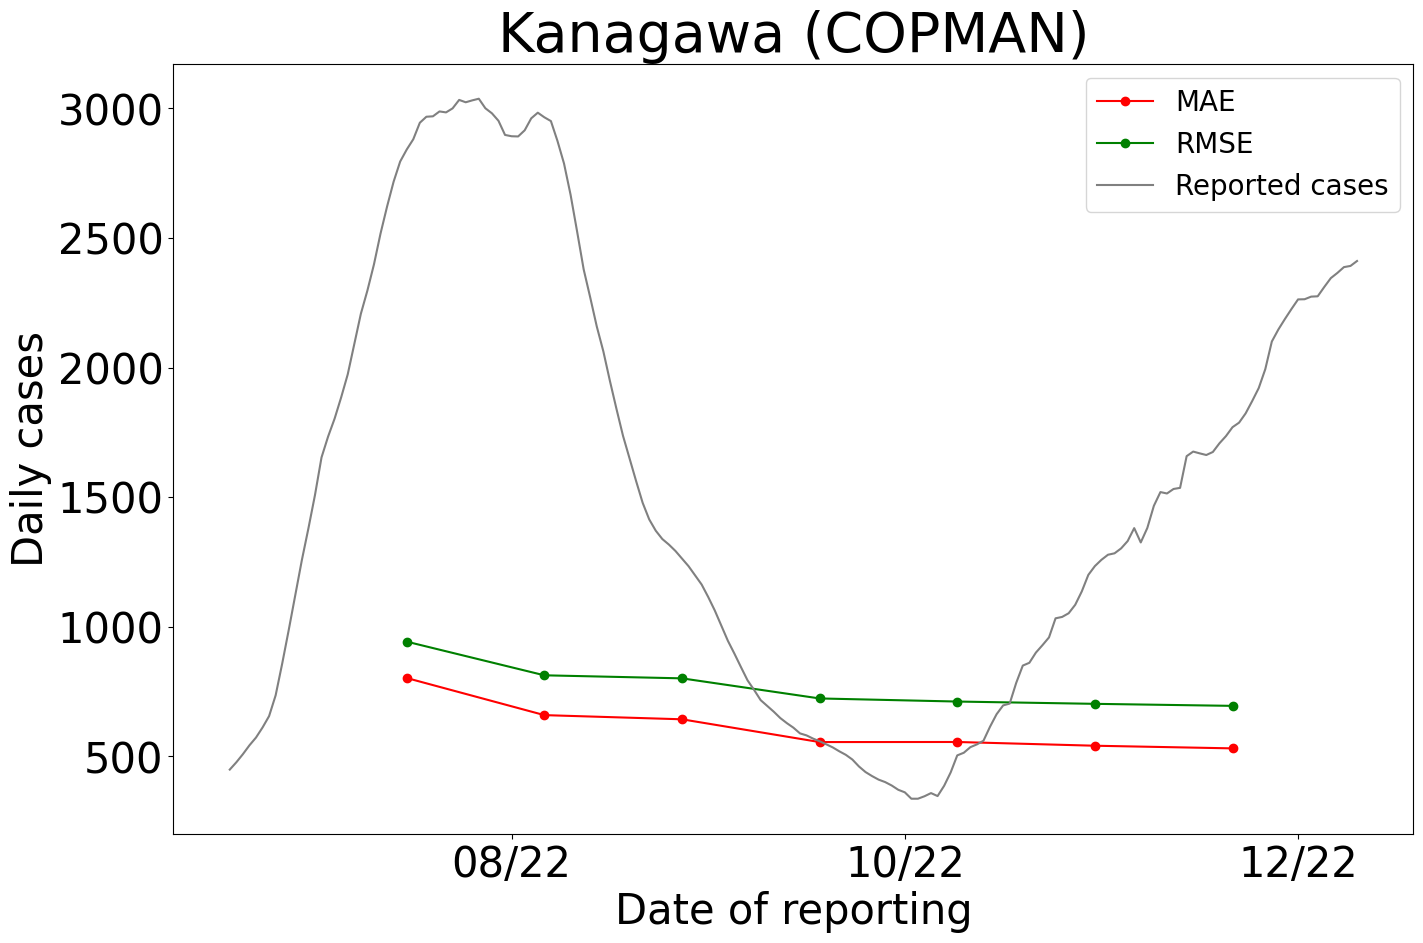

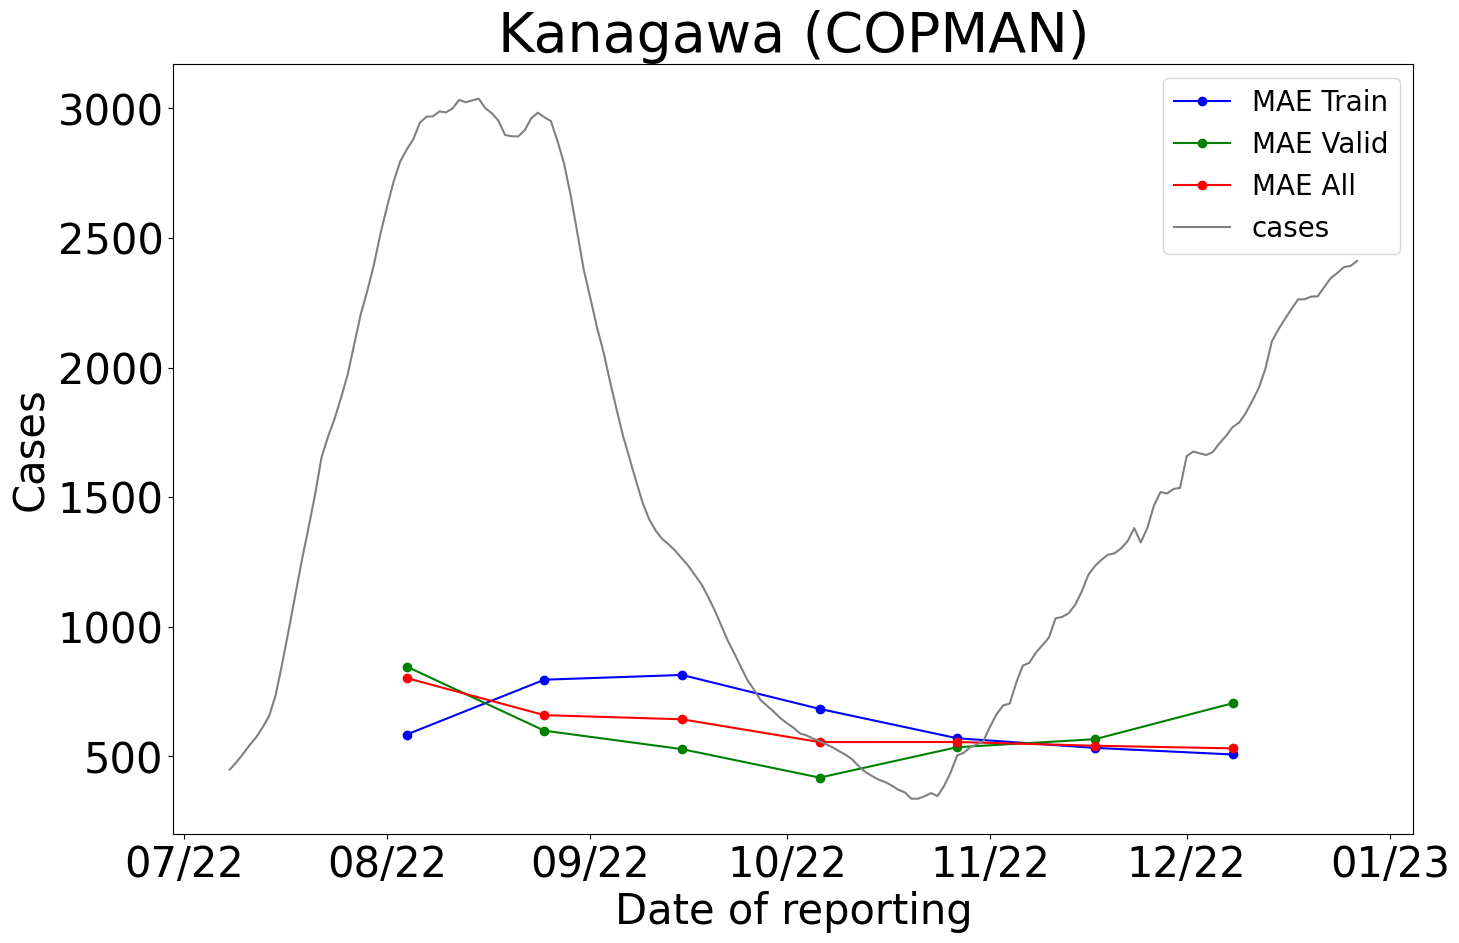

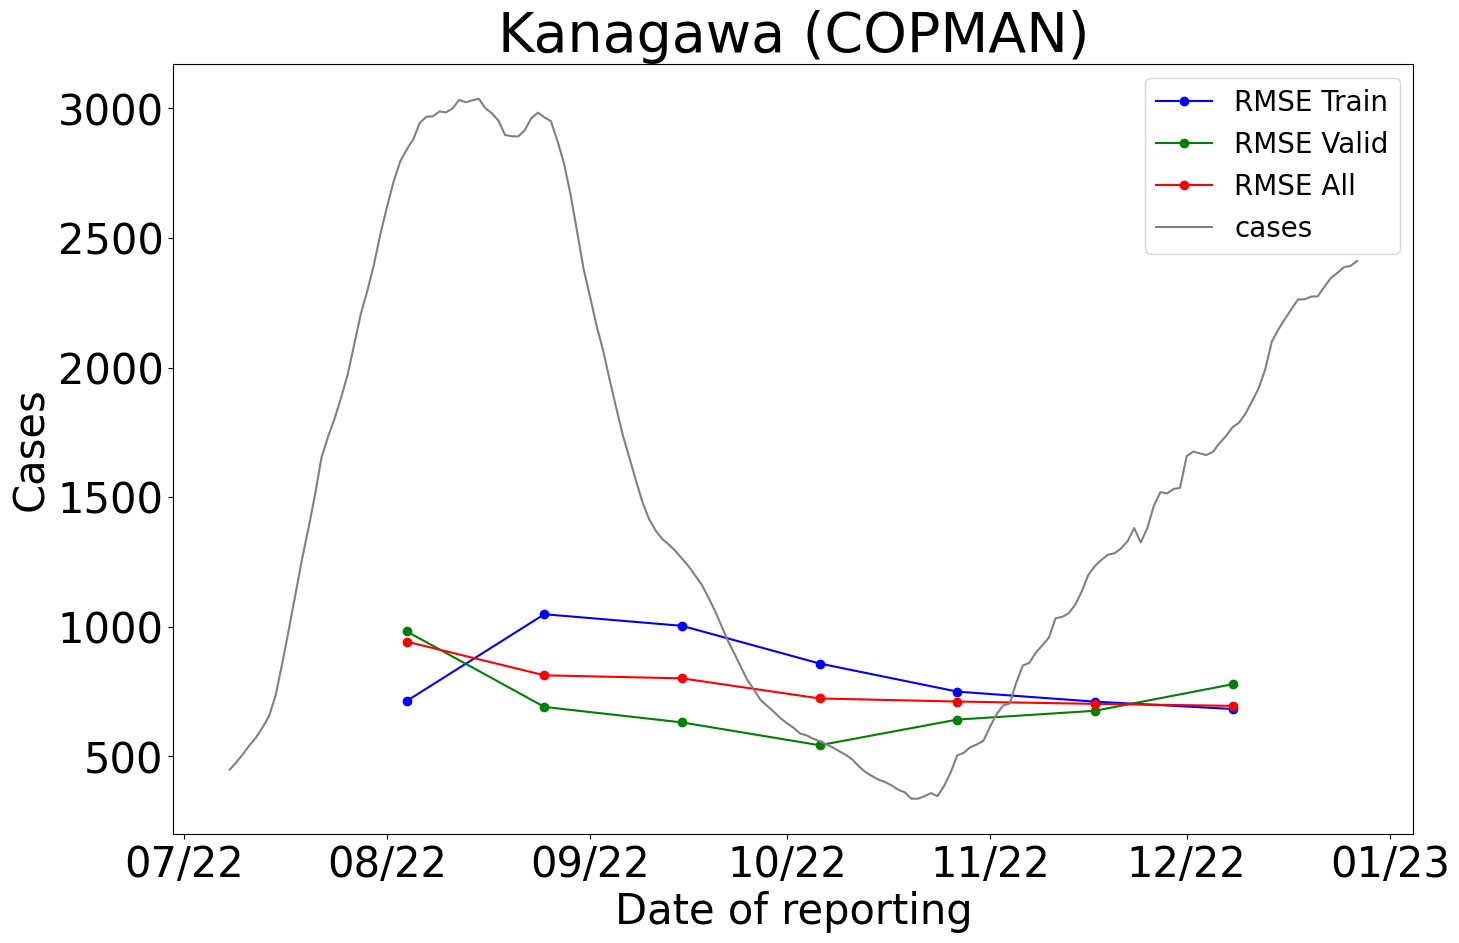

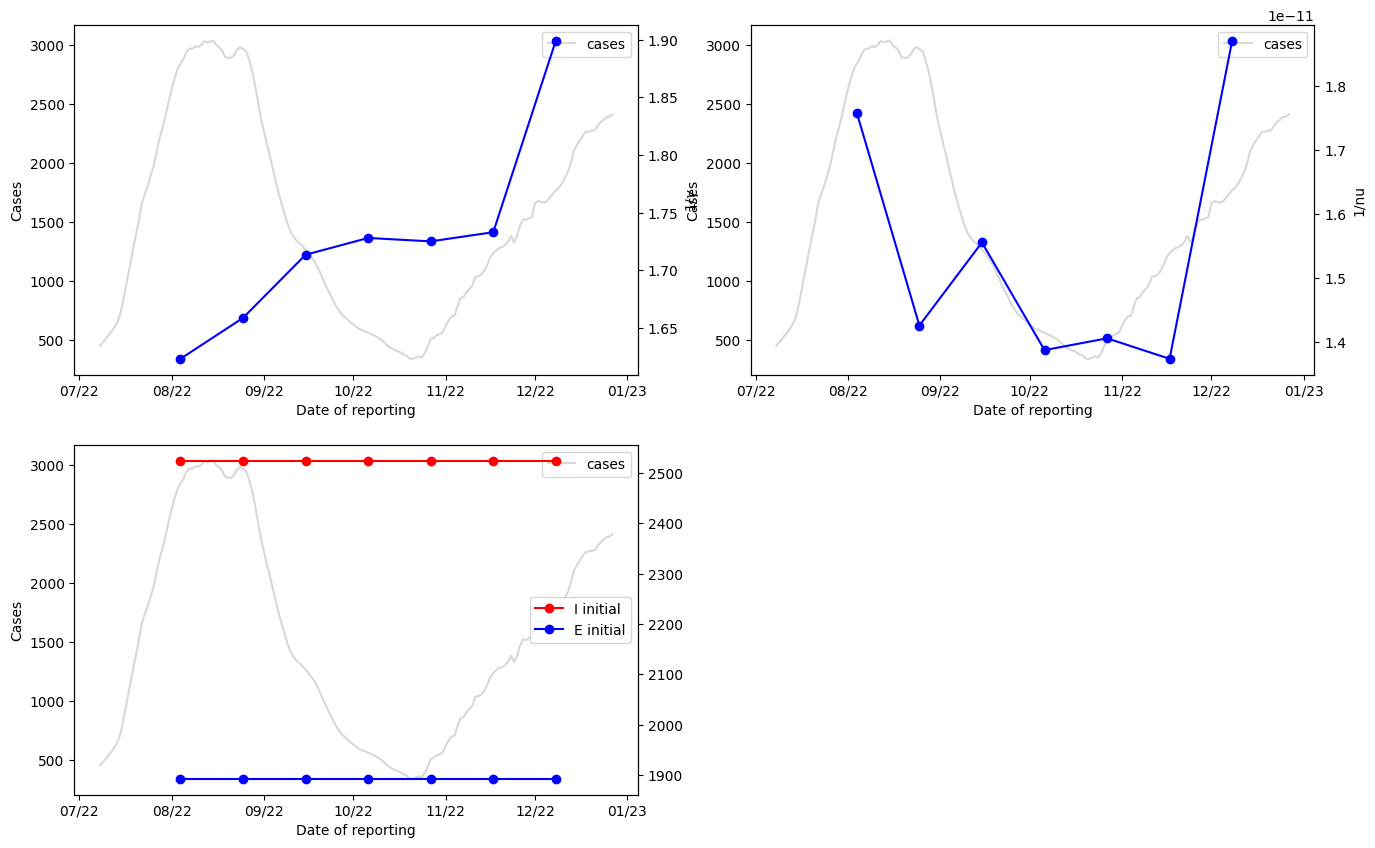

In [111]:
# Plot figure for paper
# Plot input data
fig = plt.figure(figsize=(16,10))
ax1 = fig.add_subplot(111)
years_fmt = mdates.DateFormatter('%m/%y')
ax1.set_title("DEBUGGING")
ax1.xaxis.set_major_formatter(years_fmt)
ax1.plot(pd.to_datetime(result_df["e_date"]),result_df["mae_all"],marker="o",color="r",label="MAE")
ax1.plot(pd.to_datetime(result_df["e_date"]),result_df["rmse_all"],marker="o",color="g",label="RMSE")
ax1.plot(TT["date"],TT["cases"].rolling(window=7, min_periods=1).mean(),color="grey",label="Reported cases")
plt.gca().xaxis.set_major_formatter(years_fmt)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=60))
ax1.set_title(figure_title, fontsize=40)
ax1.set_xlabel('Date of reporting',fontsize=30)
ax1.set_ylabel('Daily cases',fontsize=30)
ax1.tick_params(axis="both", labelsize=30)
ax1.legend(fontsize=20)
fig.savefig(outputfile + '/Plot_scan_mae_rmse_' + regionName + '_offset_' +  str(FLG_OFFSET) + '.png',bbox_inches="tight") 

# Plot input data debuging
fig = plt.figure(figsize=(16,10))
ax1 = fig.add_subplot(111)
years_fmt = mdates.DateFormatter('%m/%y')
ax1.set_title("DEBUGGING")
ax1.xaxis.set_major_formatter(years_fmt)
ax1.plot(pd.to_datetime(result_df["e_date"]),result_df["mae_train"],marker="o",color="b",label="MAE Train")
ax1.plot(pd.to_datetime(result_df["e_date"]),result_df["mae_valid"],marker="o",color="g",label="MAE Valid")
ax1.plot(pd.to_datetime(result_df["e_date"]),result_df["mae_all"],marker="o",color="r",label="MAE All")
ax1.plot(TT["date"],TT["cases"].rolling(window=7, min_periods=1).mean(),color="grey",label="cases")
ax1.set_title(figure_title, fontsize=40)
ax1.set_xlabel('Date of reporting',fontsize=30)
ax1.set_ylabel('Cases',fontsize=30)
ax1.tick_params(axis="both", labelsize=30)
ax1.legend(fontsize=20)
fig.savefig(outputfile + '/Plot_scan_mae_debug_' + regionName + '_offset_' +  str(FLG_OFFSET) + '.png',bbox_inches="tight") 

fig = plt.figure(figsize=(16,10))
ax1 = fig.add_subplot(111)
years_fmt = mdates.DateFormatter('%m/%y')
ax1.set_title("DEBUGGING")
ax1.xaxis.set_major_formatter(years_fmt)
ax1.plot(pd.to_datetime(result_df["e_date"]),result_df["rmse_train"],marker="o",color="b",label="RMSE Train")
ax1.plot(pd.to_datetime(result_df["e_date"]),result_df["rmse_valid"],marker="o",color="g",label="RMSE Valid")
ax1.plot(pd.to_datetime(result_df["e_date"]),result_df["rmse_all"],marker="o",color="r",label="RMSE All")
ax1.plot(TT["date"],TT["cases"].rolling(window=7, min_periods=1).mean(),color="grey",label="cases")
ax1.set_title(figure_title, fontsize=40)
ax1.set_xlabel('Date of reporting',fontsize=30)
ax1.set_ylabel('Cases',fontsize=30)
ax1.tick_params(axis="both", labelsize=30)
ax1.legend(fontsize=20)
fig.savefig(outputfile + '/Plot_scan_rmse_debug_' + regionName + '_offset_' +  str(FLG_OFFSET) + '.png',bbox_inches="tight") 


fig = plt.figure(figsize=(16,10))
ax1 = fig.add_subplot(221)
years_fmt = mdates.DateFormatter('%m/%y')
ax1.xaxis.set_major_formatter(years_fmt)
ax1.plot(TT["date"],TT["cases"].rolling(window=7, min_periods=1).mean(),color="grey",label="cases",alpha=0.3)
ax1.set_xlabel('Date of reporting')
ax1.set_ylabel('Cases')
ax1.legend()
ax2=ax1.twinx()
ax2.plot(pd.to_datetime(result_df["e_date"]),result_df["gamma"],marker="o",color="b")
ax2.set_ylabel("1/$\gamma$")

ax1 = fig.add_subplot(222)
years_fmt = mdates.DateFormatter('%m/%y')
ax1.xaxis.set_major_formatter(years_fmt)
ax1.plot(TT["date"],TT["cases"].rolling(window=7, min_periods=1).mean(),color="grey",label="cases",alpha=0.3)
ax1.set_xlabel('Date of reporting')
ax1.set_ylabel('Cases')
ax1.legend()
ax2=ax1.twinx()
ax2.plot(pd.to_datetime(result_df["e_date"]),result_df["nu"],marker="o",color="b")
ax2.set_ylabel("1/nu")

ax1 = fig.add_subplot(223)
years_fmt = mdates.DateFormatter('%m/%y')
ax1.xaxis.set_major_formatter(years_fmt)
ax1.plot(TT["date"],TT["cases"].rolling(window=7, min_periods=1).mean(),color="grey",label="cases",alpha=0.3)
ax1.set_xlabel('Date of reporting')
ax1.set_ylabel('Cases')
ax1.legend()
ax2=ax1.twinx()
ax2.plot(pd.to_datetime(result_df["e_date"]),result_df["I_init"],marker="o",color="r",label="I initial")
ax2.plot(pd.to_datetime(result_df["e_date"]),result_df["E_init"],marker="o",color="b",label="E initial")
ax2.legend()
fig.savefig(outputfile + '/Plot_scan_pars_' + regionName + '_offset_' +  str(FLG_OFFSET) + '.png',bbox_inches="tight") 